# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:47 - loss: 0.6932

  31/1875 [..............................] - ETA: 3s - loss: 0.5391   

  63/1875 [>.............................] - ETA: 3s - loss: 0.4579

  95/1875 [>.............................] - ETA: 2s - loss: 0.4164

 131/1875 [=>............................] - ETA: 2s - loss: 0.3868

 168/1875 [=>............................] - ETA: 2s - loss: 0.3654

 205/1875 [==>...........................] - ETA: 2s - loss: 0.3490

 242/1875 [==>...........................] - ETA: 2s - loss: 0.3357

 280/1875 [===>..........................] - ETA: 2s - loss: 0.3243

 313/1875 [====>.........................] - ETA: 2s - loss: 0.3159

 344/1875 [====>.........................] - ETA: 2s - loss: 0.3088

 376/1875 [=====>........................] - ETA: 2s - loss: 0.3023

 407/1875 [=====>........................] - ETA: 2s - loss: 0.2965

 439/1875 [======>.......................] - ETA: 2s - loss: 0.2911

 474/1875 [======>.......................] - ETA: 2s - loss: 0.2856

 510/1875 [=======>......................] - ETA: 2s - loss: 0.2805

 546/1875 [=======>......................] - ETA: 1s - loss: 0.2758

 582/1875 [========>.....................] - ETA: 1s - loss: 0.2715

 618/1875 [========>.....................] - ETA: 1s - loss: 0.2675

 649/1875 [=========>....................] - ETA: 1s - loss: 0.2642

 678/1875 [=========>....................] - ETA: 1s - loss: 0.2613

 705/1875 [==========>...................] - ETA: 1s - loss: 0.2587

 726/1875 [==========>...................] - ETA: 1s - loss: 0.2568

 748/1875 [==========>...................] - ETA: 1s - loss: 0.2549

 775/1875 [===========>..................] - ETA: 1s - loss: 0.2526

 799/1875 [===========>..................] - ETA: 1s - loss: 0.2507

 828/1875 [============>.................] - ETA: 1s - loss: 0.2484

 854/1875 [============>.................] - ETA: 1s - loss: 0.2465

 885/1875 [=============>................] - ETA: 1s - loss: 0.2442

 911/1875 [=============>................] - ETA: 1s - loss: 0.2424

 936/1875 [=============>................] - ETA: 1s - loss: 0.2407

 964/1875 [==============>...............] - ETA: 1s - loss: 0.2389

 987/1875 [==============>...............] - ETA: 1s - loss: 0.2375

1016/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1064/1875 [================>.............] - ETA: 1s - loss: 0.2330

1077/1875 [================>.............] - ETA: 1s - loss: 0.2322

1101/1875 [================>.............] - ETA: 1s - loss: 0.2309

1130/1875 [=================>............] - ETA: 1s - loss: 0.2294

1157/1875 [=================>............] - ETA: 1s - loss: 0.2280

1177/1875 [=================>............] - ETA: 1s - loss: 0.2270

1203/1875 [==================>...........] - ETA: 1s - loss: 0.2257

1232/1875 [==================>...........] - ETA: 1s - loss: 0.2243

1257/1875 [===================>..........] - ETA: 1s - loss: 0.2231

1281/1875 [===================>..........] - ETA: 1s - loss: 0.2220

1307/1875 [===================>..........] - ETA: 0s - loss: 0.2209

1339/1875 [====================>.........] - ETA: 0s - loss: 0.2195

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2183

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2170

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2159

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1487/1875 [======================>.......] - ETA: 0s - loss: 0.2136

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1549/1875 [=======================>......] - ETA: 0s - loss: 0.2114

1580/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1612/1875 [========================>.....] - ETA: 0s - loss: 0.2092

1644/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1677/1875 [=========================>....] - ETA: 0s - loss: 0.2071

1708/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1735/1875 [==========================>...] - ETA: 0s - loss: 0.2052

1764/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1795/1875 [===========================>..] - ETA: 0s - loss: 0.2034

1829/1875 [============================>.] - ETA: 0s - loss: 0.2024

1855/1875 [============================>.] - ETA: 0s - loss: 0.2017

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2011


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1171

  34/1875 [..............................] - ETA: 2s - loss: 0.1094

  68/1875 [>.............................] - ETA: 2s - loss: 0.1092

 101/1875 [>.............................] - ETA: 2s - loss: 0.1093

 135/1875 [=>............................] - ETA: 2s - loss: 0.1094

 169/1875 [=>............................] - ETA: 2s - loss: 0.1094

 193/1875 [==>...........................] - ETA: 2s - loss: 0.1094

 219/1875 [==>...........................] - ETA: 2s - loss: 0.1094

 250/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 282/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 313/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 343/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 373/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 404/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 436/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 468/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 501/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 533/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 565/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 597/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 628/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 660/1875 [=========>....................] - ETA: 1s - loss: 0.1082

 692/1875 [==========>...................] - ETA: 1s - loss: 0.1081

 725/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 758/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 790/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 823/1875 [============>.................] - ETA: 1s - loss: 0.1078

 855/1875 [============>.................] - ETA: 1s - loss: 0.1077

 887/1875 [=============>................] - ETA: 1s - loss: 0.1076

 920/1875 [=============>................] - ETA: 1s - loss: 0.1076

 953/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 984/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1016/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1047/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1078/1875 [================>.............] - ETA: 1s - loss: 0.1072

1109/1875 [================>.............] - ETA: 1s - loss: 0.1072

1140/1875 [=================>............] - ETA: 1s - loss: 0.1071

1171/1875 [=================>............] - ETA: 1s - loss: 0.1070

1202/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1234/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1265/1875 [===================>..........] - ETA: 0s - loss: 0.1069

1296/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1327/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1359/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1391/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1454/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1487/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1552/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1616/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1647/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1679/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1709/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1772/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1804/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1836/1875 [============================>.] - ETA: 0s - loss: 0.1058

1867/1875 [============================>.] - ETA: 0s - loss: 0.1058

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0918

  32/1875 [..............................] - ETA: 3s - loss: 0.0957

  64/1875 [>.............................] - ETA: 2s - loss: 0.0962

  95/1875 [>.............................] - ETA: 2s - loss: 0.0965

 125/1875 [=>............................] - ETA: 2s - loss: 0.0968

 156/1875 [=>............................] - ETA: 2s - loss: 0.0970

 187/1875 [=>............................] - ETA: 2s - loss: 0.0971

 219/1875 [==>...........................] - ETA: 2s - loss: 0.0972

 250/1875 [===>..........................] - ETA: 2s - loss: 0.0973

 281/1875 [===>..........................] - ETA: 2s - loss: 0.0974

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0975

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0977

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 662/1875 [=========>....................] - ETA: 1s - loss: 0.0978

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 725/1875 [==========>...................] - ETA: 1s - loss: 0.0978

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0978

 821/1875 [============>.................] - ETA: 1s - loss: 0.0978

 852/1875 [============>.................] - ETA: 1s - loss: 0.0978

 883/1875 [=============>................] - ETA: 1s - loss: 0.0978

 914/1875 [=============>................] - ETA: 1s - loss: 0.0978

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1069/1875 [================>.............] - ETA: 1s - loss: 0.0978

1097/1875 [================>.............] - ETA: 1s - loss: 0.0978

1123/1875 [================>.............] - ETA: 1s - loss: 0.0978

1153/1875 [=================>............] - ETA: 1s - loss: 0.0978

1180/1875 [=================>............] - ETA: 1s - loss: 0.0977

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1286/1875 [===================>..........] - ETA: 0s - loss: 0.0977

1317/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1818/1875 [============================>.] - ETA: 0s - loss: 0.0976

1850/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0957

  31/1875 [..............................] - ETA: 3s - loss: 0.0969

  54/1875 [..............................] - ETA: 3s - loss: 0.0965

  85/1875 [>.............................] - ETA: 3s - loss: 0.0964

 113/1875 [>.............................] - ETA: 3s - loss: 0.0963

 136/1875 [=>............................] - ETA: 3s - loss: 0.0963

 163/1875 [=>............................] - ETA: 3s - loss: 0.0962

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 387/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 668/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 720/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 780/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 811/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 843/1875 [============>.................] - ETA: 1s - loss: 0.0960

 874/1875 [============>.................] - ETA: 1s - loss: 0.0960

 904/1875 [=============>................] - ETA: 1s - loss: 0.0960

 935/1875 [=============>................] - ETA: 1s - loss: 0.0960

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1092/1875 [================>.............] - ETA: 1s - loss: 0.0960

1124/1875 [================>.............] - ETA: 1s - loss: 0.0960

1156/1875 [=================>............] - ETA: 1s - loss: 0.0960

1187/1875 [=================>............] - ETA: 1s - loss: 0.0959

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1837/1875 [============================>.] - ETA: 0s - loss: 0.0959

1869/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0980

  30/1875 [..............................] - ETA: 3s - loss: 0.0956

  60/1875 [..............................] - ETA: 3s - loss: 0.0950

  90/1875 [>.............................] - ETA: 3s - loss: 0.0949

 120/1875 [>.............................] - ETA: 3s - loss: 0.0949

 154/1875 [=>............................] - ETA: 2s - loss: 0.0949

 186/1875 [=>............................] - ETA: 2s - loss: 0.0950

 217/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 248/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 309/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 722/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 753/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 814/1875 [============>.................] - ETA: 1s - loss: 0.0951

 846/1875 [============>.................] - ETA: 1s - loss: 0.0951

 878/1875 [=============>................] - ETA: 1s - loss: 0.0951

 909/1875 [=============>................] - ETA: 1s - loss: 0.0951

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1067/1875 [================>.............] - ETA: 1s - loss: 0.0951

1099/1875 [================>.............] - ETA: 1s - loss: 0.0951

1130/1875 [=================>............] - ETA: 1s - loss: 0.0951

1163/1875 [=================>............] - ETA: 1s - loss: 0.0951

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1283/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1316/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1348/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1820/1875 [============================>.] - ETA: 0s - loss: 0.0951

1848/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

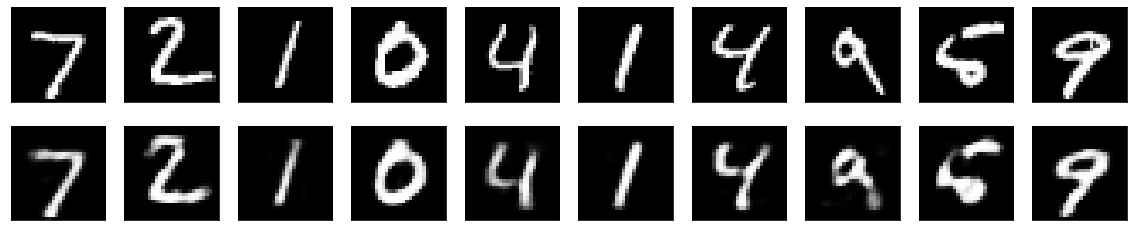

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
